<h1 align="center"> HW3 </h1>
<h2 align="center"> Ravish Chawla </h2>
<h4 align="center"> <i> Georgia Institute of Technology </i> </h4>
<h4 align="center"> April 15th, 2017</h4>

We will first start by making the necessary imports.

In [364]:
import os;

import pandas as pd;
import numpy as np;
import scipy as sp;

from gensim.models import word2vec;
import logging;

from bs4 import BeautifulSoup;
import re;
from nltk.corpus import stopwords;
import nltk.data;
import pickle;
from scipy.sparse import csr_matrix;

from sklearn.learning_curve import learning_curve;
from sklearn.metrics import pairwise_distances, roc_auc_score, roc_curve, auc;
from sklearn.neighbors import KDTree;
from sklearn.cross_validation import train_test_split

from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt;

import itertools;

from sklearn.cluster import KMeans
import time

from sklearn.ensemble import RandomForestClassifier;

In [365]:
from urllib.parse import urlencode
from urllib.request import Request, urlopen
import sys;

  
def send_to_pushover(args):

    message = '\n'.join(args);

    url = 'https://api.pushover.net/1/messages.json';
    post_fields = {'token': 'avrq1m5hnoo7khzwzmdbowmzd35z26', 'user': 'uDhMCFVpQYPSGH8WFJGFLFtwmB4gyW', 'message' : args};
    
    request = Request(url, urlencode(post_fields).encode())
    json = urlopen(request).read().decode()
    print(json)

We will now load in the data, which includes both the Labeled and Unlabeled reviews, as well as the testing dataset.

In [366]:
labeled_train = pd.read_csv('../homework1/data/labeledTrainData.tsv', header=0, delimiter='\t', quoting=3);

test = pd.read_csv('../homework1/data/testData.tsv', header=0, delimiter='\t', quoting=3);

unlabeled_train = pd.read_csv('../homework1/data/unlabeledTrainData.tsv', header=0, delimiter='\t', quoting=3);

print('Read ' + str(labeled_train['review'].size) + ' labeled train reviews, ' + \
     str(test['review'].size) + ' labeled test reviews, ' + \
                str(unlabeled_train['review'].size) + ' unlabeled reviews\n');

Read 25000 labeled train reviews, 25000 labeled test reviews, 50000 unlabeled reviews



We now implement some required helper functions, which will parse the reviews into a set of words, by removing extraneous information.

# Question 1.

In this question, we will be using the Word2Vec model to train the reviews, and get a vector representation of the reviews. We will train a model from the reviews, and one using a pre-trained model from Google. The vectorial representation will then be featurized using K Means Clustering and their corresponding cluster centers.

In [367]:
'''
Splits a review into an array of words, while removing HTML text, numbers and symbols, and \
stop words (if set to True).
'''
def review_to_wordlist(review, remove_stopwords=False):
    
    #Remove HTML
    plain_text = BeautifulSoup(review, 'html5lib').get_text();
    
    #Remove non-letters
    alphas_only = re.sub("[^a-zA-Z]", " ", plain_text);
    
    #Convert words to lower and split them
    words = alphas_only.lower().split();
    
    #Remove stopwords if True
    if remove_stopwords:
        stops = set(stopwords.words("english"));
        words = [w for w in words if not w in stops];
        
    #Return a list of words
    return(words);

In [368]:
'''
Converts a review into an array of sentences. Each sentence is an array of words on its own. Sentences\
are parsed using the NLTK Punkt tokenizer, and words are obtained using the review_to_wordlist function.
'''

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle');

def review_to_sentences(review, tokenizer, remove_stopwords=False):
    
    #Use NLTK Tokenizer to split paragraphs into sentences
    raw_sentences = tokenizer.tokenize(review.strip());
    
    #Loop over each sentence
    sentences = [];
    for raw_sentence in raw_sentences:
        #if a sentence is empty, skip it
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords));
            
    return sentences;

We need to obtain an array of Sentences using both Labeled and Unlabeled reviews. Because the values are obtained by iterating over each review, it takes a long time to run. To reduce the computational overhead, the data is dumped with Pickle to a file, and read if it already exists.

In [369]:
if os.path.exists('parsed_sentences.p'):
    print('Loading from file');
    sentences = pickle.load(open('parsed_sentences.p', 'rb'));
else:
    print('Loading from data');
    sentences = [];

    print('Parsing sentences from training set');

    labeled_train['review'].apply(lambda x: sentences.extend(review_to_sentences(x, tokenizer)));

    print('Parsing sentences from unlabeled set');

    unlabeled_train['review'].apply(lambda x: sentences.extend(review_to_sentences(x, tokenizer)));
            
    pickle.dump(sentences, open('parsed_sentences.p', 'wb'))

Loading from file


Having obtained the Sentence words, the next step is to train a Word2Vec model with Gensim. We will print Logging info as well to monitor progress. Once the model is trained, we will save the model so that it can loaded back in later.

## Section 1.a
Create vector representations for each movie post in your training set by training word2vec with context=5, embedding dimension=100, min_words=40. We’ll call the collection of these representations Z1.

In [370]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 100    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 5          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model

print("Training model...");
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling);

# We don't plan on training the model any further, so calling 
# init_sims will make the model more memory-efficient.
model.init_sims(replace=True);

model_name = "100features_40minwords_5context";
model.save(model_name);

2017-04-17 15:49:13,409 : INFO : collecting all words and their counts
2017-04-17 15:49:13,411 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-04-17 15:49:13,490 : INFO : PROGRESS: at sentence #10000, processed 225803 words, keeping 17776 word types
2017-04-17 15:49:13,551 : INFO : PROGRESS: at sentence #20000, processed 451892 words, keeping 24948 word types
2017-04-17 15:49:13,598 : INFO : PROGRESS: at sentence #30000, processed 671315 words, keeping 30034 word types


Training model...


2017-04-17 15:49:13,648 : INFO : PROGRESS: at sentence #40000, processed 897815 words, keeping 34348 word types
2017-04-17 15:49:13,700 : INFO : PROGRESS: at sentence #50000, processed 1116963 words, keeping 37761 word types
2017-04-17 15:49:13,764 : INFO : PROGRESS: at sentence #60000, processed 1338404 words, keeping 40723 word types
2017-04-17 15:49:13,818 : INFO : PROGRESS: at sentence #70000, processed 1561580 words, keeping 43333 word types
2017-04-17 15:49:13,877 : INFO : PROGRESS: at sentence #80000, processed 1780887 words, keeping 45714 word types
2017-04-17 15:49:13,937 : INFO : PROGRESS: at sentence #90000, processed 2004996 words, keeping 48135 word types
2017-04-17 15:49:13,991 : INFO : PROGRESS: at sentence #100000, processed 2226967 words, keeping 50207 word types
2017-04-17 15:49:14,043 : INFO : PROGRESS: at sentence #110000, processed 2446581 words, keeping 52081 word types
2017-04-17 15:49:14,099 : INFO : PROGRESS: at sentence #120000, processed 2668776 words, keepin

2017-04-17 15:49:18,666 : INFO : PROGRESS: at sentence #760000, processed 16990810 words, keeping 120930 word types
2017-04-17 15:49:18,727 : INFO : PROGRESS: at sentence #770000, processed 17217947 words, keeping 121703 word types
2017-04-17 15:49:18,793 : INFO : PROGRESS: at sentence #780000, processed 17448093 words, keeping 122402 word types
2017-04-17 15:49:18,856 : INFO : PROGRESS: at sentence #790000, processed 17675169 words, keeping 123066 word types
2017-04-17 15:49:18,891 : INFO : collected 123504 word types from a corpus of 17798270 raw words and 795538 sentences
2017-04-17 15:49:18,892 : INFO : Loading a fresh vocabulary
2017-04-17 15:49:19,049 : INFO : min_count=40 retains 16490 unique words (13% of original 123504, drops 107014)
2017-04-17 15:49:19,051 : INFO : min_count=40 leaves 17239125 word corpus (96% of original 17798270, drops 559145)
2017-04-17 15:49:19,104 : INFO : deleting the raw counts dictionary of 123504 items
2017-04-17 15:49:19,117 : INFO : sample=0.001 d

In [371]:
Z1 = model.wv.syn0;

## Section 1.b

Create vector representations for each movie post in your training set by loading the pretrained Google word2vec model. We’ll call the collection of these representations Z2.

We will first load in this model using the `.bin` file.

In [372]:
google_model = gensim.models.KeyedVectors.load_word2vec_format("./data/GoogleNews-vectors-negative300.bin", binary=True);

2017-04-17 15:50:06,361 : INFO : loading projection weights from ./data/GoogleNews-vectors-negative300.bin
2017-04-17 15:51:01,524 : INFO : loaded (3000000, 300) matrix from ./data/GoogleNews-vectors-negative300.bin


Next, we need to filter out words that are not present in our reviews. To do this, we will iterate through each, and keep feature vectors from words that are in our current Word index.

In [373]:
num_features = google_model.syn0.shape[1];

vocab_words = set();
for sentence in sentences:
    for word in sentence:
        vocab_words.add(word);

#Google_vecs will contain the Google vectors
google_vecs = [];

#Google_index will contain the filterd words
google_index = [];

for idx, google_word in enumerate(google_model.index2word):
    if google_word in vocab_words:
        google_vecs.append(google_model.syn0[idx]);
        google_index.append(google_word);

Z2 will be initialized sa a Numpy array of the filtered Word Vectors.

In [374]:
Z2 = np.array(google_vecs);

## Section 1.c

With k=10, do k-means clustering on each set Z1, Z2. Print a table of the words in each cluster for Z1 and for Z2.

For clustering, we will first implement a function that uses the KMeans module and obtains the clusterings on the Word vectors and their corresponding cluster centers.

In [375]:
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters);
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx;

We now obtain the Cluster centers and assignments for Z1 and Z2. I am using 10 clusters for this section because it provides a good balance between accuracy and time of computation. With larger number of clusters, the computation takes over 10 minutes, and the accuracy with the model isn't significantly higher.

In [376]:
Z1_centers, Z1_clusters = clustering_on_wordvecs(Z1, 10);

In [377]:
Z2_centers, Z2_clusters = clustering_on_wordvecs(Z2, 10);

Having obtained the Clustering assignments, we need to create a mapping of Word -> Cluster Index.

In [378]:
Z1_centroid_map = dict(zip(model.wv.index2word,Z1_clusters));

In [379]:
Z2_centroid_map = dict(zip(google_index, Z2_clusters));

The second part of this question is to obtain a list of Top words in each cluster. To do this, we will use the following function.

In [380]:
'''
Returns a DataFrame of the Closest words to each Cluster center. The closest neighbors are obtained using a \
KDTree, which is trained on the provided Word vectors. The KDTree is then queried for the top 20 words\
which are then used as indices in the Word index representation. The results are added to a dictionary,\
which is used to create and return a DataFrame.

'''
def get_top20_words(index2word, centers, wordvecs):
    tree = KDTree(wordvecs);

    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=20) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];

    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i)] = [index2word[j] for j in closest_words_idxs[i][0]]

    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1

    return df;

In [78]:
get_top20_words(model.wv.index2word, Z1_centers, Z1)

,Cluster #0,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9
1,womanizing,henderson,colony,betrayed,overwrought,it,depravity,inferno,crawling,succumb
2,gardener,moran,imperial,mistreated,unsophisticated,dvd,alienation,creepshow,carpet,sell
3,chauffeur,gavin,warsaw,approached,underplayed,rating,individuality,korda,fireplace,defend
4,physician,gallagher,colonies,ridiculed,unexciting,movie,nobility,dynasty,trucks,apply
5,hypnotist,gladys,coal,healed,incongruous,ratings,obsessions,zatoichi,trousers,accept
6,embittered,swain,refugees,confessed,patchy,review,repression,mondo,stomping,respond
7,preacher,coleman,allied,persuaded,emotive,release,awareness,ka,chains,expose
8,baron,jenkins,slums,defended,unsubtle,votes,anxiety,amicus,slug,achieve
9,millionaire,hutton,offices,victimized,transparent,this,spirituality,trinity,hose,exploit
10,secretary,byrne,laboratory,questioned,underwhelming,film,emptiness,seminal,lamp,convert


The above list shows the Top words for each cluster. The cluster centers show some coherance in the words. For instance, Cluster #2 shows values relating to a populace or geography, such as `slums`, `populace`, and `dwellers`. Cluster #5 shows movie words, such as `dvd`, `rating`, `film`, `imdb`, and `netflix`,and Cluster #6 shows some emotional and psychological words, such as `alienation`, `awareness`, `anxiety`, and `hostility`. This shows that the Word2Vec model trained well and the Clustering algorithm was properly able to distinsuish the words.

In [85]:
get_top20_words(google_index, Z2_centers, Z2)

,Cluster #0,Cluster #1,Cluster #2,Cluster #3,Cluster #4,Cluster #5,Cluster #6,Cluster #7,Cluster #8,Cluster #9
1,whaaaa,shimmeringly,ingratiates,puddy,necrotising,cappelletti,byw,needn,baird,habitude
2,needn,catchingly,destructs,clowny,dysmorphic,podge,gemma,overrided,bodas,pharisaical
3,knockaround,poundingly,raying,alrighty,tobi,tightfitting,seus,susy,greer,apocolyptic
4,tonkin,bromidic,needn,puhleeze,globus,ziploc,vivian,nbs,prashant,reactionism
5,butnot,habitude,apocolyptic,wierdo,milia,dolman,chahta,programmation,bottome,dramatis
6,dokey,gothically,dazes,fuggedaboudit,magnon,lemondrop,leeze,prashant,lhasa,aggrandising
7,booga,hokeyness,knockaround,whaaaa,fallopian,eensy,paulo,mained,scut,rightous
8,starcrossed,earthily,sssss,loooooove,marburg,mandel,claudia,butnot,dokey,conspiratory
9,susy,picturisations,spites,ughh,tryptic,toscano,buti,jacqueline,susy,repugnantly
10,drews,laceratingly,dokey,immitating,andromeda,brule,poter,reston,nbs,bromidic


## Section 1.d 

Featurize the training and test reviews in Z1, Z2 to produce design matrices X1, X2 as described in part 3 of the blog series. Basically, each review is converted into a bag of centroids feature vector with each vector component representing the count of the number of words in that review that belong in that component’s cluster.

We will first start by implementing the function that computes the Bag of Centroids.

In [381]:
'''
This function computes the Bag of Centroids using the provided
word list and Centroids mapping.
'''
def create_bag_of_centroids(wordlist, word_centroid_map):
    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max(word_centroid_map.values()) + 1;

    bag_of_centroids = np.zeros(num_centroids, dtype="float32");

    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count 
    # by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word];
            bag_of_centroids[index] += 1;

    return bag_of_centroids;

Similar to before, because the computation for creating the Bag of Centroids takes a long time, we use Pickle to load in the array if it has already been computed before, and dump it if it hasn't.

The first thing we need is a List of Clean reviews, which are similar to the Sentences array computed before, but with StopWords removed.

In [382]:
if os.path.exists('clean_reviews.p'):
    print('Loading from file');
    (clean_all_reviews, clean_train_reviews, clean_test_reviews) = pickle.load(open('clean_reviews.p', 'rb'));
else:
    print('Loading from data');
    all_reviews = np.concatenate((labeled_train['review'], unlabeled_train['review']));
    clean_all_reviews = [];

    for review in all_reviews:
        clean_all_reviews.append(review_to_wordlist(review, remove_stopwords=True));
        
    clean_train_reviews = []
    
    for review in labeled_train["review"]:
        clean_train_reviews.append( review_to_wordlist(review, remove_stopwords=True));
        
    clean_test_reviews = []
    for review in test["review"]:
        clean_test_reviews.append( review_to_wordlist( review, remove_stopwords=True ))
    
    pickle.dump((clean_all_reviews, clean_train_reviews, clean_test_reviews), open('clean_reviews.p', 'wb'));

Loading from file


Now we compute the Z1 and Z2 Bag of Centroids.

In [383]:
if os.path.exists('z1_centroids.p'):
    print('Loading from file');
    Z1_centroids = pickle.load(open('z1_centroids.p', 'rb'));
else:
    print('Loading from data');
    Z1_centroids = np.zeros((all_reviews.shape[0], 10), dtype='float32');
    counter = 0;
    for review in clean_all_reviews:
        Z1_centroids[counter] = create_bag_of_centroids(review, Z1_centroid_map);
        counter = counter + 1;
        
    pickle.dump(Z1_centroids, open('z1_centroids.p', 'wb'));

Loading from file


In [384]:
if os.path.exists('z2_centroids.p'):
    print('Loading from file');
    Z2_centroids = pickle.load(open('z2_centroids.p', 'rb'));
else:
    print('Loading from data');
    Z2_centroids = np.zeros((all_reviews.shape[0], 10), dtype='float32');
    counter = 0;
    for review in clean_all_reviews:
        Z2_centroids[counter] = create_bag_of_centroids(review, Z2_centroid_map);
        counter = counter + 1;

    pickle.dump(Z2_centroids, open('z2_centroids.p', 'wb'));

Loading from file


Using the Centroids from the Training examples, we will obtain the Test feature vectors for both Z1 and z2.

In [385]:
if os.path.exists('z1_centroids_test.p'):
    print('Loading from file');
    Z1_centroids_test = pickle.load(open('z1_centroids_test.p', 'rb'));
else:
    print('Loading from data');
    Z1_centroids_test = np.zeros((len(clean_test_reviews), 10), dtype='float32');
    counter = 0;
    for review in clean_test_reviews:
        Z1_centroids_test[counter] = create_bag_of_centroids(review, Z1_centroid_map);
        counter = counter + 1;
        
    pickle.dump(Z1_centroids_test, open('z1_centroids_test.p', 'wb'));

Loading from file


In [386]:
if os.path.exists('z2_centroids_test.p'):
    print('Loading from file');
    Z2_centroids_test = pickle.load(open('z2_centroids_test.p', 'rb'));
else:
    print('Loading from data');
    Z2_centroids_test = np.zeros((len(clean_test_reviews), 10), dtype='float32');
    counter = 0;
    for review in clean_test_reviews:
        Z2_centroids_test[counter] = create_bag_of_centroids(review, Z2_centroid_map);
        counter = counter + 1;
        
    pickle.dump(Z2_centroids_test, open('z2_centroids_test.p', 'wb'));

Loading from file


## Section 1.e Save X1, X2 

In [387]:
X1 = Z1_centroids;
X2 = Z2_centroids;

In [388]:
X1_test = Z1_centroids_test;
X2_test = Z2_centroids_test;

# Question 2

In this question, we will use Latent Derilicht Model for Topic Modeling, and featureize the words based on the assignments of each to a topic.

The first thing we do is implement a function that uses Gensim's LDA model to do Topic Modeling using the provided Sentences as corpus.

In [413]:
'''
This function will run Topic Modeling on the provided sentences and number of topics,
and return the Topic Distribution for them. If id2word is provided, then use it, otherwise use a new one.
'''
def lda_model(sentences_arr, num_topics, id2word=None):
    
    #We compute the id to word dictionary with the sentences, and the corpus from it's bag of words array.
    
    if id2word == None:
        id2word = gensim.corpora.Dictionary(sentences_arr);
    
    corpus = [id2word.doc2bow(text) for text in sentences_arr];
    
    #The TFidF pre-processor is not used because the overall AUC is lower with it.
    #tfidf = gensim.models.TfidfModel(corpus);
    #corpus_tfidf = tfidf[corpus];
    
    #We now train the model with the correct parameters.

    lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics);
    
    #We get the Topic distributions for each word in the Corpus.
    lda_corpus = lda[corpus];
    
    #Because the format of the lda_corpus is different than the one we need, we will iterate over it
    #and build a Numpy array.
    dist_arr = [];
    for i in range(0, len(corpus)):
        dist = [0] * num_topics;

        for j in lda_corpus[i]:
            dist[j[0]] = j[1];

        dist_arr.append(dist);
    
    dist_np = np.array(dist_arr);
    
    return id2word, dist_np;

## Section 2.a

Perform LDA topic modeling on your training set with ntopics=10. Featurize each email by its topic composition. We’ll call this representation X3.

In [391]:
id2w_X3, X3 = lda_model(clean_train_reviews, 10);

2017-04-17 16:01:41,741 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-04-17 16:01:43,390 : INFO : adding document #10000 to Dictionary(51374 unique tokens: ['weirded', 'undamaged', 'herbie', 'incubus', 'havoc']...)
2017-04-17 16:01:44,967 : INFO : adding document #20000 to Dictionary(67660 unique tokens: ['weirded', 'undamaged', 'doncha', 'donnovan', 'herbie']...)
2017-04-17 16:01:45,835 : INFO : built Dictionary(74065 unique tokens: ['weirded', 'undamaged', 'doncha', 'donnovan', 'herbie']...) from 25000 documents (total 2988089 corpus positions)
2017-04-17 16:01:48,822 : INFO : using symmetric alpha at 0.1
2017-04-17 16:01:48,824 : INFO : using symmetric eta at 1.3501653952609195e-05
2017-04-17 16:01:48,842 : INFO : using serial LDA version on this node
2017-04-17 16:01:53,082 : INFO : running online LDA training, 10 topics, 1 passes over the supplied corpus of 25000 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents,

2017-04-17 16:02:18,605 : INFO : topic #8 (0.100): 0.010*"film" + 0.008*"like" + 0.007*"movie" + 0.006*"one" + 0.005*"good" + 0.005*"would" + 0.004*"plot" + 0.004*"really" + 0.004*"scenes" + 0.004*"even"
2017-04-17 16:02:18,608 : INFO : topic diff=0.728688, rho=0.408248
2017-04-17 16:02:18,612 : INFO : PROGRESS: pass 0, at document #14000/25000
2017-04-17 16:02:21,937 : INFO : merging changes from 2000 documents into a model of 25000 documents
2017-04-17 16:02:22,542 : INFO : topic #9 (0.100): 0.013*"film" + 0.011*"one" + 0.007*"movie" + 0.006*"story" + 0.006*"like" + 0.005*"would" + 0.005*"first" + 0.005*"good" + 0.004*"character" + 0.004*"time"
2017-04-17 16:02:22,543 : INFO : topic #5 (0.100): 0.017*"film" + 0.009*"one" + 0.005*"life" + 0.005*"man" + 0.004*"young" + 0.003*"well" + 0.003*"story" + 0.003*"also" + 0.003*"time" + 0.003*"films"
2017-04-17 16:02:22,545 : INFO : topic #8 (0.100): 0.010*"film" + 0.008*"like" + 0.007*"movie" + 0.006*"one" + 0.005*"good" + 0.005*"would" + 0.0

2017-04-17 16:03:00,967 : INFO : topic #9 (0.100): 0.012*"film" + 0.010*"one" + 0.006*"story" + 0.005*"first" + 0.005*"would" + 0.005*"like" + 0.004*"character" + 0.004*"movie" + 0.004*"good" + 0.004*"well"
2017-04-17 16:03:00,969 : INFO : topic #3 (0.100): 0.005*"film" + 0.004*"one" + 0.003*"german" + 0.003*"war" + 0.003*"match" + 0.003*"would" + 0.002*"hitler" + 0.002*"first" + 0.002*"also" + 0.002*"english"
2017-04-17 16:03:00,970 : INFO : topic #6 (0.100): 0.017*"film" + 0.005*"one" + 0.005*"like" + 0.005*"people" + 0.004*"see" + 0.004*"time" + 0.004*"movie" + 0.004*"story" + 0.004*"well" + 0.004*"world"
2017-04-17 16:03:00,972 : INFO : topic #5 (0.100): 0.018*"film" + 0.009*"one" + 0.005*"man" + 0.005*"life" + 0.005*"young" + 0.004*"story" + 0.004*"father" + 0.004*"well" + 0.003*"also" + 0.003*"performance"
2017-04-17 16:03:00,973 : INFO : topic #8 (0.100): 0.009*"film" + 0.007*"one" + 0.007*"like" + 0.006*"movie" + 0.005*"good" + 0.005*"horror" + 0.005*"plot" + 0.004*"get" + 0.00

## Section 2.b

Repeat part (a) with ntopics=20 (this will be X4).

In [399]:
id2w_X4, X4 = lda_model(clean_train_reviews, 20);

2017-04-18 10:56:38,013 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-04-18 10:56:41,526 : INFO : adding document #10000 to Dictionary(51374 unique tokens: ['weirded', 'undamaged', 'herbie', 'incubus', 'havoc']...)
2017-04-18 10:56:43,675 : INFO : adding document #20000 to Dictionary(67660 unique tokens: ['weirded', 'undamaged', 'doncha', 'donnovan', 'herbie']...)
2017-04-18 10:56:44,646 : INFO : built Dictionary(74065 unique tokens: ['weirded', 'undamaged', 'doncha', 'donnovan', 'herbie']...) from 25000 documents (total 2988089 corpus positions)
2017-04-18 10:56:50,249 : INFO : using symmetric alpha at 0.05
2017-04-18 10:56:50,255 : INFO : using symmetric eta at 1.3501653952609195e-05
2017-04-18 10:56:50,285 : INFO : using serial LDA version on this node
2017-04-18 10:56:58,488 : INFO : running online LDA training, 20 topics, 1 passes over the supplied corpus of 25000 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents

2017-04-18 10:57:30,354 : INFO : topic #5 (0.050): 0.015*"film" + 0.008*"movie" + 0.006*"one" + 0.005*"people" + 0.005*"see" + 0.005*"like" + 0.004*"story" + 0.004*"also" + 0.004*"character" + 0.003*"films"
2017-04-18 10:57:30,361 : INFO : topic diff=1.002905, rho=0.408248
2017-04-18 10:57:30,369 : INFO : PROGRESS: pass 0, at document #14000/25000
2017-04-18 10:57:34,382 : INFO : merging changes from 2000 documents into a model of 25000 documents
2017-04-18 10:57:35,135 : INFO : topic #17 (0.050): 0.009*"game" + 0.007*"one" + 0.005*"film" + 0.004*"like" + 0.003*"world" + 0.003*"would" + 0.003*"henry" + 0.003*"well" + 0.003*"new" + 0.003*"time"
2017-04-18 10:57:35,141 : INFO : topic #12 (0.050): 0.011*"show" + 0.011*"series" + 0.009*"great" + 0.008*"one" + 0.008*"movie" + 0.008*"like" + 0.007*"episode" + 0.006*"time" + 0.006*"best" + 0.006*"also"
2017-04-18 10:57:35,143 : INFO : topic #18 (0.050): 0.035*"film" + 0.010*"movie" + 0.008*"one" + 0.007*"story" + 0.005*"even" + 0.005*"would" 

2017-04-18 10:58:15,089 : INFO : merging changes from 1000 documents into a model of 25000 documents
2017-04-18 10:58:15,641 : INFO : topic #16 (0.050): 0.010*"film" + 0.007*"one" + 0.005*"cartoon" + 0.005*"like" + 0.004*"life" + 0.004*"fox" + 0.004*"movie" + 0.004*"animation" + 0.003*"great" + 0.003*"well"
2017-04-18 10:58:15,642 : INFO : topic #12 (0.050): 0.014*"show" + 0.013*"series" + 0.011*"great" + 0.009*"one" + 0.008*"best" + 0.007*"episode" + 0.007*"like" + 0.006*"time" + 0.006*"first" + 0.006*"also"
2017-04-18 10:58:15,644 : INFO : topic #14 (0.050): 0.012*"movie" + 0.008*"one" + 0.007*"would" + 0.005*"like" + 0.004*"love" + 0.004*"life" + 0.004*"really" + 0.004*"way" + 0.004*"see" + 0.004*"family"
2017-04-18 10:58:15,645 : INFO : topic #7 (0.050): 0.010*"one" + 0.006*"film" + 0.005*"town" + 0.004*"two" + 0.004*"joe" + 0.003*"batman" + 0.003*"new" + 0.003*"john" + 0.003*"police" + 0.003*"man"
2017-04-18 10:58:15,646 : INFO : topic #3 (0.050): 0.025*"movie" + 0.015*"show" + 0.

Generating the Test Examples. We will use the Test reviews and the trained models on the LDA model's id2word to obtain the Test examples.

In [392]:
_, X3_test = lda_model(clean_test_reviews, 10, id2w_X3);

2017-04-17 16:04:05,957 : INFO : using symmetric alpha at 0.1
2017-04-17 16:04:05,958 : INFO : using symmetric eta at 1.3501653952609195e-05
2017-04-17 16:04:05,979 : INFO : using serial LDA version on this node
2017-04-17 16:04:10,184 : INFO : running online LDA training, 10 topics, 1 passes over the supplied corpus of 25000 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2017-04-17 16:04:10,185 : INFO : PROGRESS: pass 0, at document #2000/25000
2017-04-17 16:04:13,500 : INFO : merging changes from 2000 documents into a model of 25000 documents
2017-04-17 16:04:14,035 : INFO : topic #9 (0.100): 0.013*"film" + 0.008*"one" + 0.006*"like" + 0.006*"movie" + 0.005*"story" + 0.005*"well" + 0.005*"time" + 0.004*"see" + 0.004*"good" + 0.004*"even"
2017-04-17 16:04:14,037 : INFO : topic #3 (0.100): 0.013*"movie" + 0.009*"like" + 0.007*"one" + 0.007*"would" + 0.006*"film" + 0.005*"see" + 0.0

2017-04-17 16:04:37,401 : INFO : topic #4 (0.100): 0.015*"film" + 0.010*"one" + 0.006*"movie" + 0.005*"great" + 0.004*"well" + 0.004*"like" + 0.004*"man" + 0.004*"even" + 0.003*"see" + 0.003*"many"
2017-04-17 16:04:37,403 : INFO : topic #2 (0.100): 0.011*"show" + 0.009*"film" + 0.008*"one" + 0.007*"series" + 0.006*"movie" + 0.006*"like" + 0.005*"would" + 0.004*"good" + 0.004*"even" + 0.004*"time"
2017-04-17 16:04:37,404 : INFO : topic #5 (0.100): 0.007*"one" + 0.005*"film" + 0.004*"like" + 0.003*"good" + 0.003*"comedy" + 0.003*"police" + 0.003*"two" + 0.003*"even" + 0.003*"also" + 0.003*"time"
2017-04-17 16:04:37,405 : INFO : topic #6 (0.100): 0.039*"movie" + 0.013*"film" + 0.009*"like" + 0.007*"one" + 0.007*"time" + 0.007*"good" + 0.006*"would" + 0.005*"movies" + 0.005*"great" + 0.005*"really"
2017-04-17 16:04:37,408 : INFO : topic diff=0.405217, rho=0.377964
2017-04-17 16:04:37,412 : INFO : PROGRESS: pass 0, at document #16000/25000
2017-04-17 16:04:40,575 : INFO : merging changes fr

2017-04-17 16:05:15,619 : INFO : topic #7 (0.100): 0.008*"one" + 0.006*"film" + 0.005*"like" + 0.004*"get" + 0.004*"movie" + 0.004*"good" + 0.004*"man" + 0.004*"well" + 0.003*"guy" + 0.003*"gets"
2017-04-17 16:05:15,621 : INFO : topic #3 (0.100): 0.007*"like" + 0.007*"match" + 0.006*"one" + 0.005*"cartoon" + 0.005*"show" + 0.004*"would" + 0.003*"movie" + 0.003*"short" + 0.003*"character" + 0.003*"good"
2017-04-17 16:05:15,624 : INFO : topic diff=0.244527, rho=0.277350


In [400]:
_, X4_test = lda_model(clean_test_reviews, 20, id2w_X4);

2017-04-18 10:59:09,152 : INFO : using symmetric alpha at 0.05
2017-04-18 10:59:09,153 : INFO : using symmetric eta at 1.3501653952609195e-05
2017-04-18 10:59:09,167 : INFO : using serial LDA version on this node
2017-04-18 10:59:17,749 : INFO : running online LDA training, 20 topics, 1 passes over the supplied corpus of 25000 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2017-04-18 10:59:17,750 : INFO : PROGRESS: pass 0, at document #2000/25000
2017-04-18 10:59:22,147 : INFO : merging changes from 2000 documents into a model of 25000 documents
2017-04-18 10:59:23,060 : INFO : topic #9 (0.050): 0.012*"film" + 0.010*"like" + 0.010*"one" + 0.009*"movie" + 0.005*"time" + 0.005*"story" + 0.004*"good" + 0.003*"well" + 0.003*"love" + 0.003*"see"
2017-04-18 10:59:23,062 : INFO : topic #12 (0.050): 0.017*"film" + 0.014*"movie" + 0.007*"one" + 0.007*"like" + 0.005*"story" + 0.004*"great" +

2017-04-18 10:59:50,194 : INFO : topic #9 (0.050): 0.007*"film" + 0.007*"one" + 0.005*"like" + 0.004*"german" + 0.003*"time" + 0.003*"man" + 0.003*"young" + 0.003*"movie" + 0.003*"life" + 0.003*"british"
2017-04-18 10:59:50,199 : INFO : topic #0 (0.050): 0.007*"film" + 0.005*"one" + 0.005*"good" + 0.004*"movie" + 0.004*"would" + 0.004*"much" + 0.003*"even" + 0.003*"character" + 0.003*"match" + 0.003*"scene"
2017-04-18 10:59:50,202 : INFO : topic #13 (0.050): 0.011*"movie" + 0.009*"one" + 0.007*"film" + 0.007*"like" + 0.005*"story" + 0.005*"man" + 0.004*"good" + 0.004*"character" + 0.004*"life" + 0.004*"would"
2017-04-18 10:59:50,203 : INFO : topic #4 (0.050): 0.034*"movie" + 0.011*"one" + 0.010*"like" + 0.009*"film" + 0.007*"good" + 0.007*"even" + 0.006*"would" + 0.006*"really" + 0.006*"people" + 0.006*"movies"
2017-04-18 10:59:50,211 : INFO : topic diff=0.567343, rho=0.377964
2017-04-18 10:59:50,219 : INFO : PROGRESS: pass 0, at document #16000/25000
2017-04-18 10:59:54,408 : INFO : m

2017-04-18 11:00:31,220 : INFO : topic #8 (0.050): 0.030*"game" + 0.015*"movie" + 0.010*"holmes" + 0.007*"bond" + 0.007*"games" + 0.006*"one" + 0.005*"argento" + 0.004*"good" + 0.004*"virus" + 0.004*"opera"
2017-04-18 11:00:31,225 : INFO : topic #11 (0.050): 0.025*"horror" + 0.011*"one" + 0.008*"film" + 0.008*"killer" + 0.007*"house" + 0.007*"movie" + 0.005*"dead" + 0.004*"gore" + 0.004*"like" + 0.004*"jack"
2017-04-18 11:00:31,237 : INFO : topic diff=0.321420, rho=0.277350


## Section 2.c

Print tables of words for each of the topics from (a) and (b)

Using the results of of Section 2.a and 2.b, we will go through each topic and show words for each by obtaining them, and then building a DataFrame on them.

In [339]:
'''
Obtains a Word dictionary DataFrame by iterating through each topic and adding it's word to a list.
'''
def get_word_dict(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn=20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    
    return pd.DataFrame(word_dict);

The Table of Words for Topic Modeling with 10 Topics.

In [348]:
get_word_dict(lda_X3, 10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,powell,movie,kidman,film,freddy,morals,werewolf,trailer,cinderella,woody
1,kathryn,film,dont,movie,brando,sellers,sandler,chuck,fulci,pitt
2,mildred,bad,enterprise,story,sentinel,muppet,stiller,santa,carrey,tracy
3,posters,good,omen,life,sabrina,snowman,rochester,ted,homicide,dating
4,vance,really,aliens,man,melissa,absurdity,bbc,min,lucas,medium
5,damme,like,mickey,one,lars,cats,mysteries,online,creep,creatures
6,joseph,one,worms,like,cliche,expectation,frankie,victim,che,hartley
7,goof,movies,spock,also,forbes,edie,beetle,titanic,zombi,ustinov
8,barman,story,travesty,well,dourif,berkowitz,bo,elvira,arkin,renaissance
9,hysterically,see,quantum,director,independence,muppets,scrooge,month,spike,colonel


The Table of Words for Topic Modeling with 20 Topics (scroll to the right to see all columns).

In [349]:
get_word_dict(lda_X4, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20
0,cagney,fay,scrooge,gandhi,beatty,columbo,movie,bollywood,movie,film,creep,movie,cinderella,sinatra,enterprise,freddy,sentinel,vance,paulie,brando
1,tyson,scariest,australian,astaire,homicide,mysteries,film,beetle,show,movie,sutherland,show,connery,reed,bourne,walken,bug,sabrina,erika,demons
2,scifi,frankie,beckham,miyazaki,hardy,glass,bad,laura,series,man,olivia,vampire,blob,tarzan,mickey,kathryn,gundam,sucker,karate,ninja
3,judi,waters,dourif,grayson,ustinov,creators,good,buffy,film,action,et,like,lugosi,dont,spock,mildred,altman,bodyguard,straightforward,dumbest
4,busby,hop,cassavetes,twelve,laurel,tomatoes,really,resort,good,one,childish,funny,kurosawa,emma,rooney,miller,reverend,stalked,thoughtful,scarface
5,underlying,cassidy,gackt,tip,duchovny,ape,like,mcqueen,movies,story,aunts,great,rat,madonna,arkin,lisa,mason,melissa,eleniak,raines
6,battlestar,deniro,casino,mclaglen,redneck,hartley,story,amitabh,like,war,spine,good,perry,roth,fantasies,gere,funding,shepherd,gentleman,aniston
7,shanghai,gooding,crocodile,root,auteur,virus,one,stargate,see,great,danish,lousy,divine,faith,laws,melting,portuguese,hark,popping,burgess
8,classified,shore,doc,fascinated,forbes,haunted,movies,madsen,great,world,des,really,hudson,carol,lundgren,liar,griffith,darren,maddy,barman
9,kilmer,carl,biko,row,lopez,lab,would,pole,really,character,vet,film,sirk,advantage,admirer,cats,randolph,sarah,commenting,hanks


# Question 3

In this question, we will use Random Forest classifier, and tune it on the 4 Design matrices obtained in the previous question. We will then plot the ROC curves for each.

In [414]:
'''
Runs a Linear Random Forest Classifier on the provided matrix using
uniformly random values for parameters, to choose values that best fits
the matrix. Using the best value for parameters, 20% of the dataset is 
predicted.
'''
def rf_classification(X, labels):
    
    #Dataset and labels is split between a 80% / 20% split
    train_point = int(0.8*X.shape[0]);
    
    train_split = csr_matrix(X[:train_point,:]);
    test_split = csr_matrix(X[train_point:,:]);
    
    train_label = labels.iloc[:train_point];
    test_label = labels.iloc[train_point:];

    #Initialization
    best_split = 10;
    best_leaf = 10;
    best_n = 10;
    best_score = np.NaN;
    
    worst_score = np.NaN;
    
    start = time.time();
    
    for i in range(0, 30):
        
        #A random value for C is obtained and a SVM Classifier is initialized with it
        rand_split = int(np.random.uniform(1, 1000));
        rand_leaf = int(np.random.uniform(1, 1000));
        
        rfc = RandomForestClassifier(n_estimators=100, min_samples_leaf=rand_leaf, min_samples_split=rand_split);
        
        #The SVM Classifier is scored on a 5-fold cross validation with ROC_AUC metric
        train_sizes, train_scores, valid_scores = learning_curve(rfc, train_split, train_label, cv=5, scoring='roc_auc');

        #If the mean score from the classifier is better than previous scores, the values are updated
        mean_valid_score = np.mean(valid_scores);
        if np.isnan(best_score) or mean_valid_score > best_score:
            best_score = mean_valid_score;
            best_leaf = rand_leaf;
            best_split = rand_split;
        
        
        #If the mean score from the classifier is worse than prevoius scores, the value is 
        #also updated. This is used to calcualte the Lift value
        if np.isnan(worst_score) or mean_valid_score < worst_score:
            worst_score = mean_valid_score;

        #sys.stdout.write('Leaf: ' + str(rand_leaf) + 'Split: ' + str(rand_split) + 'Acc: ' + mean_valid_score);
        sys.stdout.write("\rCompleted iteration " + str(i+1) + " in " + str(time.time() - start) + 's');
        start = time.time();
        
    sys.stdout.write("\r                                                                         ");

    #print('\nBest params obtained: ' + 'Min Leaf: ' + str(best_leaf) + ' Min Split: ' + str(best_split));
    
    best_rfc = RandomForestClassifier(n_estimators=100, min_samples_leaf=best_leaf, min_samples_split=best_split);
    best_rfc.fit(train_split, train_label);
    
    preds = best_rfc.predict_proba(test_split);
    
    fp_rate, tp_rate, threshold = roc_curve(test_label, preds[:,1]);
        
    lift = best_score - worst_score;
        
    return fp_rate, tp_rate, best_rfc;

We need to obtain the Training data next. To do this, we need to get Labeled records, and their corresponding labels.

In [401]:
train_split = len(labeled_train);

X1_train = X1[:train_split];
X2_train = X2[:train_split];
X3_train = X3[:train_split];
X4_train = X4[:train_split];

X_labels = labeled_train['sentiment'];

## Section 3.a

Properly train and tune a collection of random forest classifiers using cross-validation for each of the design matrices X1...X4. You should end up with four classifiers, M1...M4.

For this, we will divide each of the 4 Design Matrices using the Train-Test split, and obtain the best set of parameters by tuning them with the Random Forest.

In [408]:
X1_fpr, X1_tpr, M1 = rf_classification(X1_train, X_labels);

In [409]:
X2_fpr, X2_tpr, M2 = rf_classification(X2_train, X_labels);

In [410]:
X3_fpr, X3_tpr, M3 = rf_classification(X3_train, X_labels);

In [411]:
X4_fpr, X4_tpr, M4 = rf_classification(X4_train, X_labels);

In [332]:
'''
A ROC AUC Curve is plotted given the true and 
false positive rate values.
'''
def plot_roc_auc_curves(fp_rates, tp_rates, labels, title='Receiver Operator Characteristic'):
    colors = ['b', 'g', 'r', 'c', 'k', 'm', 'y'];
    styles = ['solid', 'dashed', 'dashdot', 'dotted']
    
    roc_aucs = [auc(fp_rates[i], tp_rates[i]) for i in range(len(fp_rates))];
    plt.figure(figsize=(8, 6))
    
    plt.style.use('fivethirtyeight');
    plt.title(title);
    for i in range(len(fp_rates)):
        plt.plot(fp_rates[i], tp_rates[i], colors[i], label=labels[i] + ' = %0.2f'%roc_aucs[i], linewidth=1.5);
    plt.legend(loc='lower right');
    plt.plot([0,1], [0,1], 'r:', linewidth=1.5);
    plt.xlim([0.0,1.0]);
    plt.ylim([0.0,1.0]);
    plt.ylabel('True Positive Rate');
    plt.xlabel('False Positive Rate');
    plt.show();

## Section 3.b

Plot the ROCs for each classifier computed on the test set. Plot all ROCs on the same plot, but use different linestyles.

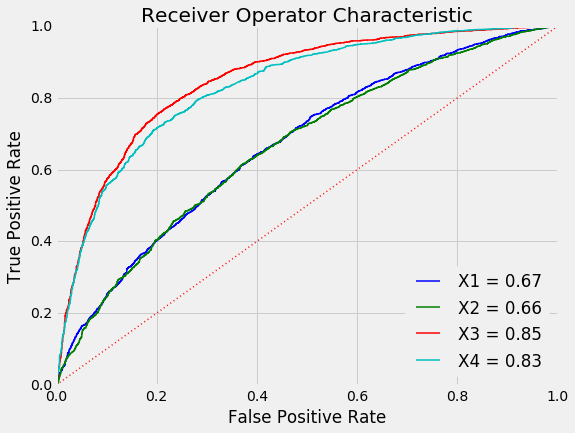

In [333]:
plot_roc_auc_curves([X1_fpr, X2_fpr, X3_fpr, X4_fpr], [X1_tpr, X2_tpr, X3_tpr, X4_tpr], ['X1', 'X2', 'X3', 'X4']);

As the graph shows, the values for X1 and X2 are close to each other, as are those of X3 and X4. However, the two pairs are different from each other, drastically. This shows that Latent Derilicht Analysis model works better than Word2Vec Clustering.

We need a function to write predictions to a file to put on Kaggle.

In [359]:
'''
Creates a Kaggle submission from predictions o a Test feature set.
'''
def create_submission(test, predictions, filename):
    output = pd.DataFrame( data={"id":test["id"], "sentiment":predictions} )
    output.to_csv( filename + ".csv", index=False, quoting=3)

Now we need to generate the submissions based on predictions on the Test dataset.

In [363]:
X1_preds = X1_rf.predict_log_proba(X1_test);

X2_preds = X2_rf.predict_proba(X2_test);

X3_preds = X3_rf.predict_proba(X3_test);

X4_preds = X4_rf.predict_proba(X4_test);

create_submission(test, X1_preds[:,1], 'x1_preds.csv'); #0.63490
create_submission(test, X2_preds[:,1], 'x2_preds.csv'); #0.62905
create_submission(test, X3_preds[:,1], 'x3_preds.csv'); #0.83593
create_submission(test, X4_preds[:,1], 'x4_preds.csv'); #0.81746


 Test Set      | Kaggle Prediction Score 
 ------------- |:-------------:| -----:
 X 1     | 0.63490
 X 2      | 0.62905      
 X 3        | 0.83593      
 X 4 | 0.81746
 
Proof of Submission:

<html>
<img src='kaggle.png' width=500px></img>
</html>

## Section 1.c

Which featurization technique works best for sentiment classification? Is this better or worse than the simple bag-of-words approach? What are at least three things you could do to improve the efficacy of the classifier?

The results show that Topic Modeling with LDA using 10 Topics works best for Sentiment classification. Although the results for 20 topics is close, it is slightly lower.

The results are similar for this model to those with a simple bag of words model, as computed in Homework 1. Using TfIdf in that homework results in an accuracy of around 0.89, which was better than the accuracy acheived in this assignment. However, the difference in AUC is only around 5-6%, which shows that this model is able to acheive similarly good results. With more parameter tuning, it should be possible to get higher accuracy/AUC with this model as well. Furthermore, the intermediate results of Word clusters show that Topic Modeling and Word2Vec works really well in gathering similar categories of Words in word analysis, such as words that have similar meaning or context. This was not possible with TfIdf, which shows that Bag of Words is not nearly as good in Semantic classification with some features. There are 3 things I would do to improve this classifier:


1. I would try more and better Parameter tuning techniques. Although my AUC was high enough with the last 2 models, I think it could be further improved. The approach I would use for parameter tuning is Grid Search CV with SKlearn, and I would try to tune more than just 2 parameters, including the Number of Estimators.

2. I would try a different model than Random Forests. In Homework 1, we used SVM, and saw good overall AUC with it, and lower with Random Forest. Although Random Forests are an ensemble technique, they do not guarantee high accuracy with this dataset, and other models should be explored before settling on one. The models I would test are going to be SVM and Logistic Regression. If the results with those models are good, I would combine them with the Random Forest model as a stronger ensemble set to obtain even higher accuracy.

3. Another thing I would try is different featurization techniques with LDA. We see a drastic improvement in results with LDA, up to 85% accuracy, and the word lists show that there is a strong coherance between words of a collection between topics. I think the approaches I would try are going to be to try different parameters with LDA, such as the number of topics, and whether there should be a different pre-processor for the corpus. I used TfIdf pre-processor with LDA, and saw a decrease in accuracy, but perhaps a different one would be more useful. For instance, using the results from the Google's word2vec model and piping them through the LDA. These techniques could provide an improvement in overall accuracy.

4. The last thing I would try is get more data. As of right now, we have 25,000 reviews, where each has multiple words. Although the dataset is large, having more data will improve the model, specifically is the dataset is labeled.